In [5]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Cannot import mxnet.


In [17]:
from skimage.exposure import rescale_intensity

In [18]:
from skimage.transform import rotate

In [2]:
# Does not work for the mxnet version on 3/30/2017
# model_dir_name = 'Sat16ClassFinetuned'
# model_name = 'Sat16ClassFinetuned'
# model_iteration = 10
# output_symbol_name = 'flatten_output'
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'saturation_mean_224.npy'))

# model_dir_name = 'vgg16-blue'
# model_name = 'vgg16-blue'
# model_iteration = 0
# output_symbol_name = 'fc7_output'
# output_dim = 4096
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'vgg_mean.npy'))

# model_dir_name = 'vgg19'
# model_name = 'vgg19'
# model_iteration = 0
# output_symbol_name = 'fc8_output'

# model_dir_name = 'inception-bn'
# model_name = 'Inception-BN'
# model_iteration = 126
# output_symbol_name = 'flatten_output'
# mean_img = mx.nd.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.nd'))['mean_img'].asnumpy()

model_dir_name = 'inception-bn-blue'
download_from_s3(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name), is_dir=True)
model_name = 'inception-bn-blue'
model_iteration = 0
output_symbol_name = 'flatten_output'
output_dim = 1024
mean_img = np.load(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# Reference on how to predict with mxnet model:
# https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
model0, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, model_name), 0)
flatten_output = model0.get_internals()[output_symbol_name]
if HOST_ID == 'workstation':
    model = mx.mod.Module(context=[mx.gpu(i) for i in range(1)], symbol=flatten_output)
else:
    model = mx.mod.Module(context=[mx.gpu(i) for i in range(8)], symbol=flatten_output)

# Increase batch_size to 500 does not save any time.
batch_size = 256
model.bind(data_shapes=[('data', (batch_size,1,224,224))], for_training=False)
model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)

# model_dir_name = 'inception-bn-sat'
# model_name = 'inception-bn-sat'
# model_iteration = 0
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# model = mx.model.FeedForward.load(os.path.join(MODEL_ROOTDIR, model_dir_name, model_name), model_iteration, ctx=mx.gpu())

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:52: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [8]:
# Visualize network topology

# a = mx.viz.plot_network(flatten_output, shape={"data":(1, 1, 224, 224)}, node_attrs={"shape":'rect',"fixedsize":'false'})
# a.render(model_name)

In [3]:
patch_size = 224
half_size = patch_size/2
stride = 56

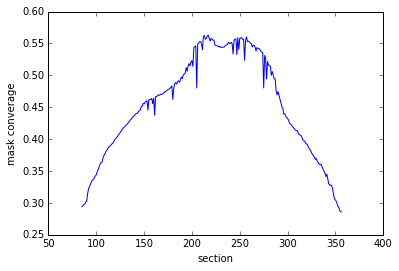

In [16]:
# This shows that a mask covers 50% to 75% of the full area, so predicting only on masks roughly halves the time.

stack = 'MD661'
image_width, image_height = metadata_cache['image_shape'][stack]
first_detect_sec, last_detect_sec = metadata_cache['section_limits'][stack]
a = image_width / 32 * image_height / 32
mask_coverage = {sec: np.count_nonzero(DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, section=sec))/float(a)
for sec in range(first_detect_sec, last_detect_sec+1) if not is_invalid(stack=stack, sec=sec)}
plt.plot(mask_coverage.keys(), mask_coverage.values());
plt.xlabel('section');
plt.ylabel('mask converage');

In [5]:
prep_id = 2
input_img_version = None

In [61]:
# for stack in all_stacks:
for stack in ['MD589']:
    
#     download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, version='cropped'), is_dir=True)
#     download_from_s3(DataManager.get_image_dir_v2(stack=stack, prep_id=prep_id, version=input_img_version), 
#                      is_dir=True)
    # download takes 300 sec.
    
    print stack
    section_to_filename = metadata_cache['sections_to_filenames'][stack]
    
    image_width, image_height = metadata_cache['image_shape'][stack]
    grid_spec = (patch_size, stride, image_width, image_height)

    sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)
    
#     for sec in metadata_cache['valid_sections'][stack]:
#     for sec in range(first_sec, last_sec+1):
    for sec in range(170, 171):
#         if is_invalid(stack=stack, sec=sec):
#             continue  
#         if section_to_filename[sec].split('-')[1][0] == 'F':
#             continue
#         if section_to_filename[sec].split('-')[1][0] == 'N':
#             continue
                        
        sys.stderr.write('\nSection %d.\n' % sec)

        # Use grids only on mask.
        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=prep_id, section=sec)
        indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
        sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
        
#         Use grids on the entire frame.
#         indices_roi = range(len(sample_locations))

        n = len(indices_roi)
        sys.stderr.write('%d samples.\n' % n)
        
        t = time.time()
#         im = DataManager.load_image_v2(stack=stack, section=sec, prep_id=prep_id, version=input_img_version, resol='lossless')[..., 2]
        im = DataManager.load_image_v2(stack=stack, section=sec, prep_id=prep_id, version='gray', resol='lossless')
        sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s
        

MD589
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD589/MD589_prep2_lossless_gray/MD589-N29-2015.07.30-17.58.29_MD589_3_0087_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD589/MD589_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_prep2_lossless_gray/MD589-N29-2015.07.30-17.58.29_MD589_3_0087_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD589/MD589_prep2_lossless_gray/MD589-N29-2015.07.30-17.58.29_MD589_3_0087_prep2_lossless_gray.tif"



Section 170.
locate patches: 0.02 seconds
42858 samples.
load image: 3.70 seconds


In [62]:
from scipy.spatial.distance import cdist
np.argmin(cdist(sample_locations[indices_roi], np.array([[8064, 10624]])))

25437

In [63]:
# sample_locations_roi = sample_locations[indices_roi][39474:39474+batch_size]
sample_locations_roi = sample_locations[indices_roi][25437:25437+batch_size]

patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
                    for x, y in sample_locations_roi]) # n x 224 x 224

In [71]:
extra_margin = 200
patches_enlarged = np.array([im[y-half_size-extra_margin:y+half_size+extra_margin, 
                                x-half_size-extra_margin:x+half_size+extra_margin]
                    for x, y in sample_locations_roi])

In [115]:
features_allNormalizations = {}

patches_allNormalizations = {}
# for low in range(0, 500, 100):
#     for high in range(100, 1000, 100):
for low in range(0, 256, 64):
    for high in range(63, 300, 64):
        if low < high:
#             patches_allNormalizations[(low, high)] = 255 - rescale_intensity(patches, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
            ps = rescale_intensity(patches, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
            pse = rescale_intensity(patches_enlarged, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
        
            for r in np.arange(-45, 60, 15):
                pr = img_as_ubyte(np.array([rotate(p, angle=r)[p.shape[1]/2-224/2:p.shape[1]/2+224/2, p.shape[0]/2-224/2:p.shape[0]/2+224/2] for p in pse]))
                patches_allNormalizations[(low, high, r)] = pr.copy()
                patches_mean_subtracted = pr - mean_img
                patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

    #         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
    #                             for x, y in sample_locations_roi]) # n x 224 x 224 x 1
    #         patches_mean_subtracted_input = np.rollaxis(patches, 3, 1) - mean_img # n x 3 x 224 x 224

#                 sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t)) # ~ 20s / 140k patches

                # For mxnet 0.9.4, using 80000 patches in a NDArrayIter works but using 90000 patches causes error:
                # TypeError: Invalid type '<type 'numpy.ndarray'>' for data, should be NDArray or numpy.ndarray

                t1 = time.time()        
                data_iter = mx.io.NDArrayIter(
                                patches_mean_subtracted_input, 
                                batch_size=batch_size,
                                shuffle=False)
                outputs = model.predict(data_iter, always_output_list=True)
                features = outputs[0].asnumpy()

                features_allNormalizations[(low,high,r)] = features

        #         data_iter.reset()
                del data_iter

        #         n_each_iter = 80000
        #         for b in range(0, n, n_each_iter):
        #             data_iter = mx.io.NDArrayIter(
        #                             patches_mean_subtracted_input[b:b+n_each_iter], 
        #                             batch_size=batch_size,
        #                             shuffle=False)

        #             # Reference on how to predict with mxnet model:
        #             # https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
        # #             model.bind(data_iter.provide_data, for_training=False)
        # #             model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)
        #             outputs = model.predict(data_iter, always_output_list=True)
        #             features[b:b+n_each_iter] = outputs[0].asnumpy()

        #             del data_iter

                sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1)) 

predict: 0.40 seconds
predict: 0.40 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.41 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.40 seconds
predict: 0.39 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.40 seconds
predict: 0.38 seconds
predict: 0.39 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.39 seconds
predict: 0.38 seconds
predict: 0.39 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0.38 seconds
predict: 0

In [19]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

In [20]:
structure = '7N'
svm_id = 38

clf_allClasses = {}

clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
download_from_s3(clf_fp)
if os.path.exists(clf_fp):
    clf_allClasses[structure] = joblib.load(clf_fp)

In [21]:
clf = clf_allClasses[structure]

probs_allNormalizations = {}

for (lo,hi,r), features in features_allNormalizations.iteritems():
    probs = clf.predict_proba(features)[:, clf.classes_.tolist().index(1.)]
    probs_allNormalizations[(lo,hi,r)] = probs

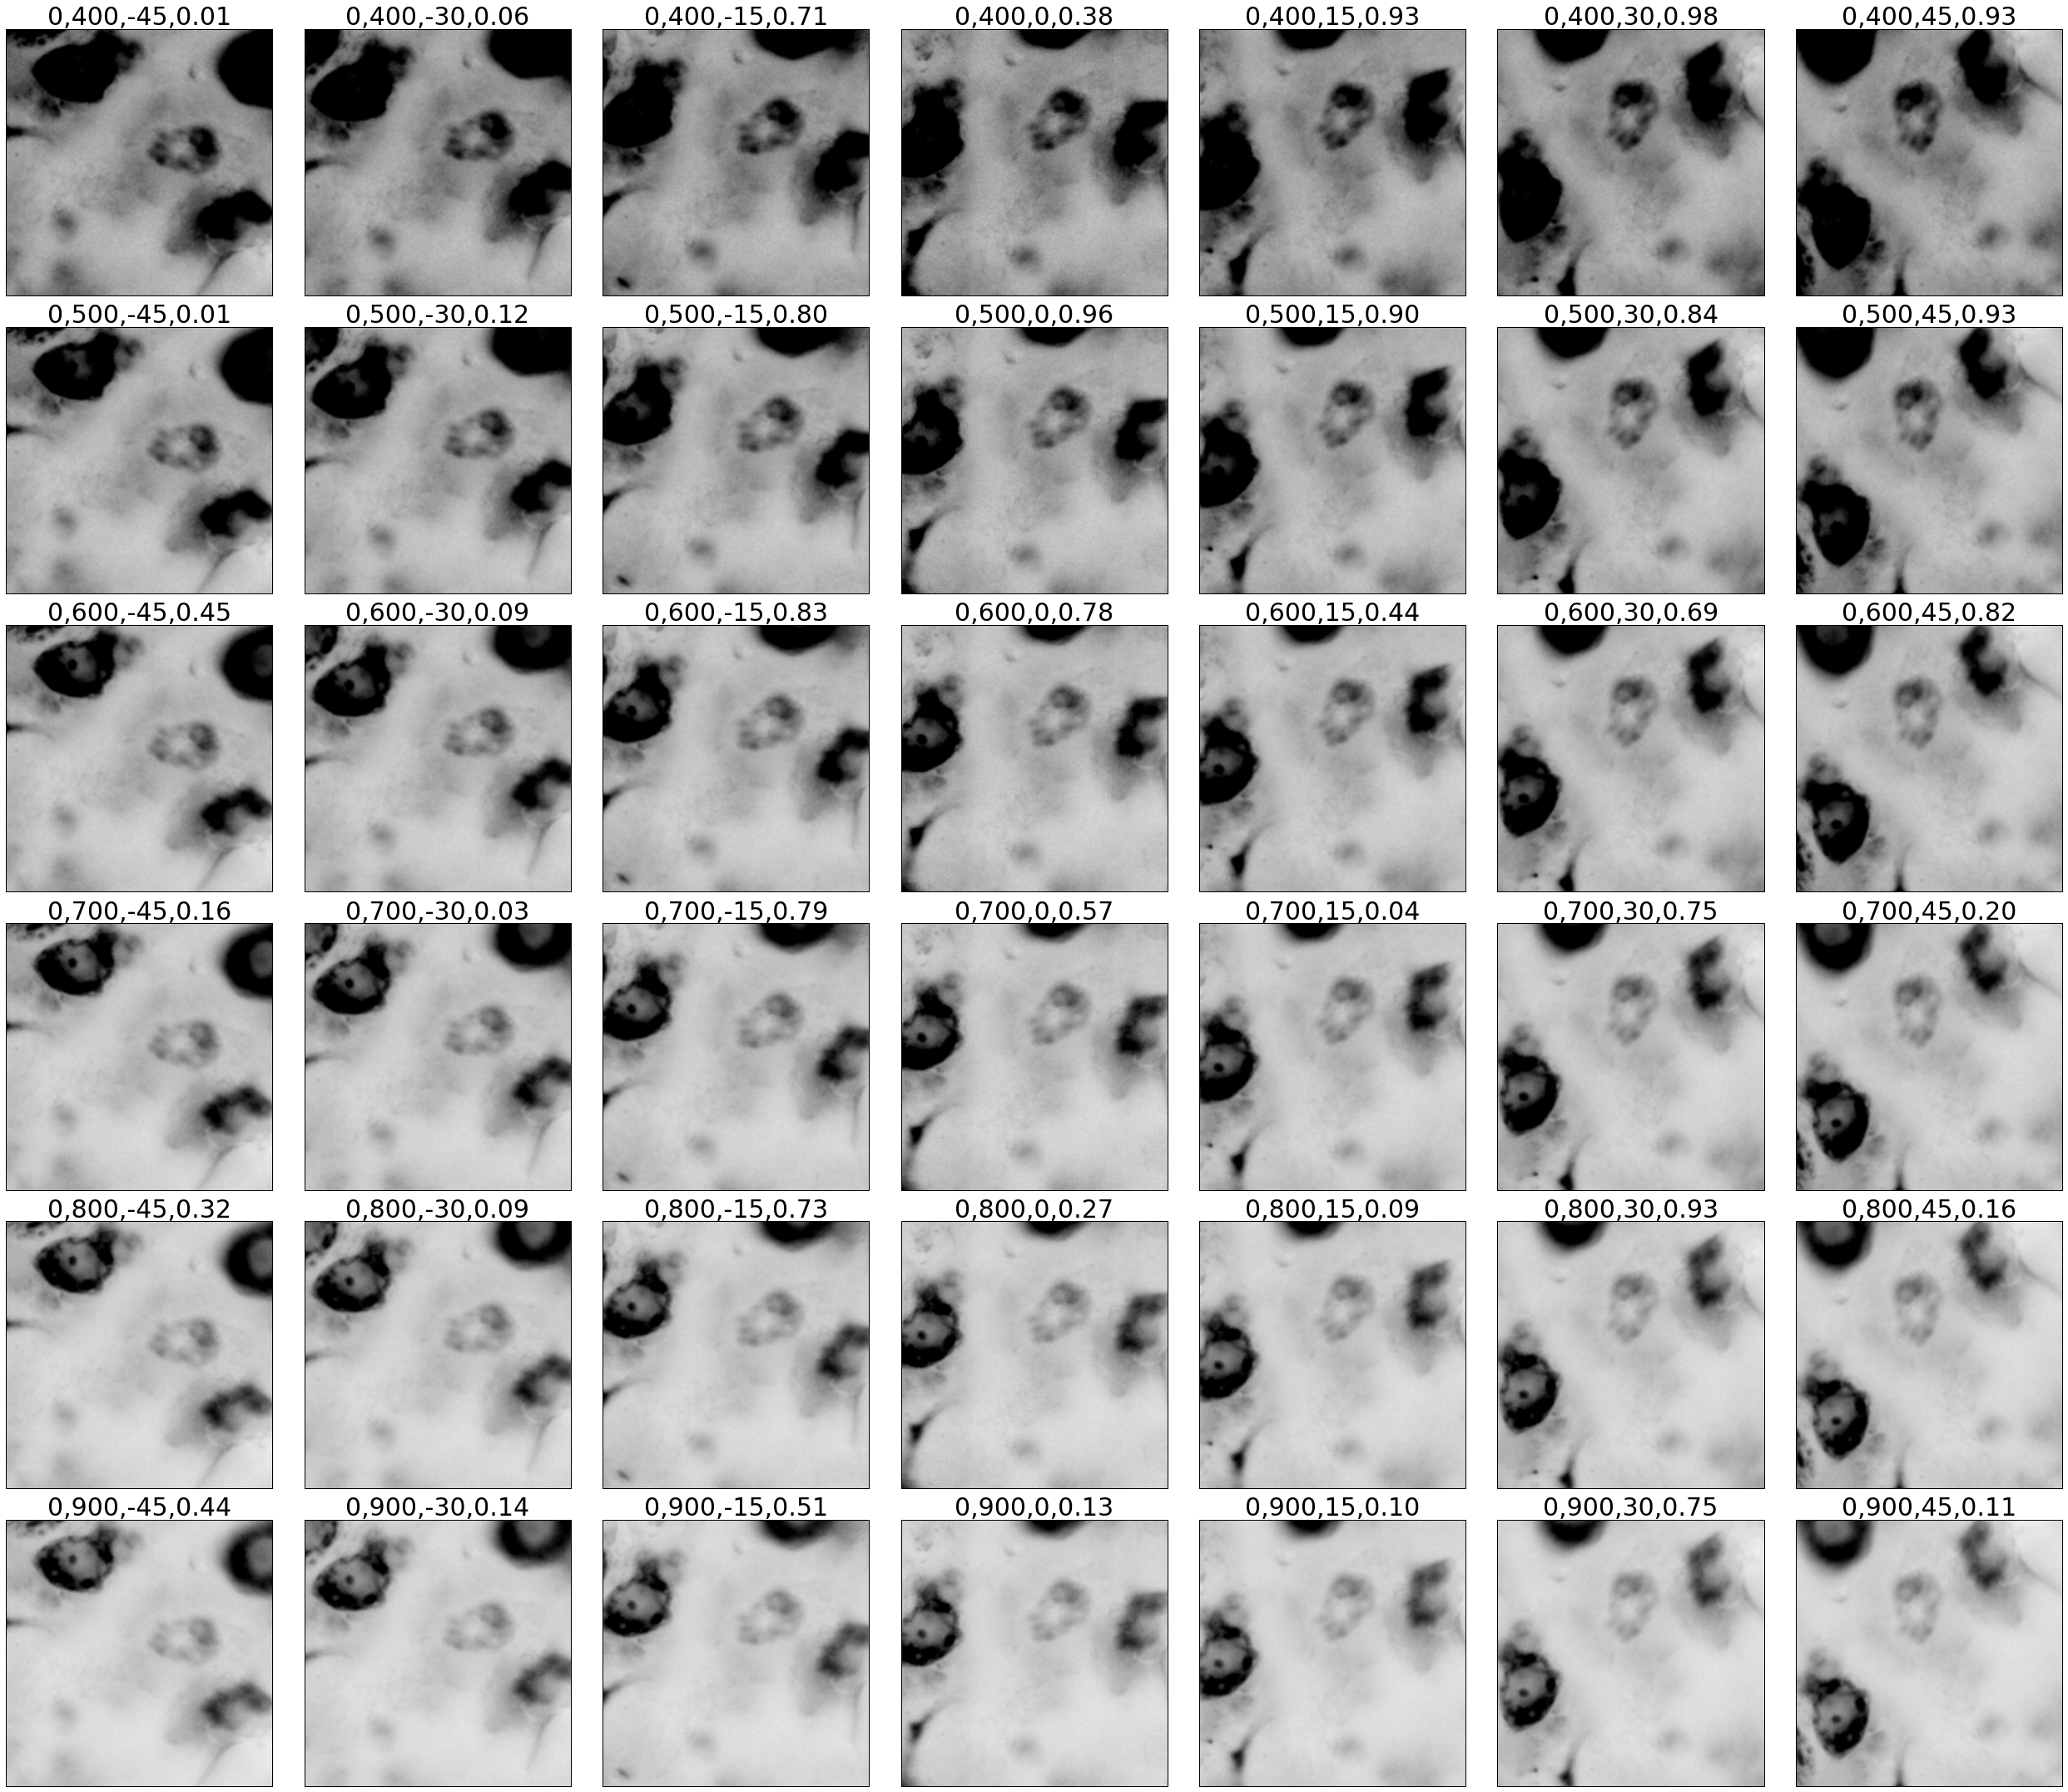

In [22]:
titles = ['%d,%d,%d,%.2f' % (lo, hi, r, probs[0]) for (lo,hi,r), probs in sorted(probs_allNormalizations.items()) if lo == 0]
pas = [pts[0] for (lo,hi,r), pts in sorted(patches_allNormalizations.items()) if lo == 0]
display_images_in_grids(pas, nc=7, titles=titles, vmin=0, vmax=255, cmap=plt.cm.gray)

In [9]:
# for stack in all_stacks:
for stack in ['MD661']:
    
#     download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, version='cropped'), is_dir=True)
#     download_from_s3(DataManager.get_image_dir_v2(stack=stack, prep_id=prep_id, version=input_img_version), 
#                      is_dir=True)
    # download takes 300 sec.
    
    print stack
    section_to_filename = metadata_cache['sections_to_filenames'][stack]
    
    image_width, image_height = metadata_cache['image_shape'][stack]
    grid_spec = (patch_size, stride, image_width, image_height)

    sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)
    
#     for sec in metadata_cache['valid_sections'][stack]:
#     for sec in range(first_sec, last_sec+1):
    for sec in range(170, 171):
#         if is_invalid(stack=stack, sec=sec):
#             continue  
#         if section_to_filename[sec].split('-')[1][0] == 'F':
#             continue
#         if section_to_filename[sec].split('-')[1][0] == 'N':
#             continue
                        
        sys.stderr.write('\nSection %d.\n' % sec)

        # Use grids only on mask.
        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=prep_id, section=sec)
        indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
        sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
        
#         Use grids on the entire frame.
#         indices_roi = range(len(sample_locations))

        n = len(indices_roi)
        sys.stderr.write('%d samples.\n' % n)
        
        t = time.time()
        im = DataManager.load_image_v2(stack=stack, section=sec, prep_id=prep_id, version=input_img_version, resol='lossless')[..., 2]
#         im = DataManager.load_image_v2(stack=stack, section=sec, prep_id=prep_id, version='gray', resol='lossless')
        sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s
        

MD661



Section 170.
locate patches: 0.04 seconds
58403 samples.
/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:1748: UserWarning: unpack: string size must be a multiple of element size
  warnings.warn("unpack: %s" % e)
load image: 104.72 seconds


In [10]:
from scipy.spatial.distance import cdist
np.argmin(cdist(sample_locations[indices_roi], np.array([[9564, 11496]])))

39498

In [11]:
sample_locations_roi = sample_locations[indices_roi][[39498]*batch_size]

patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
                    for x, y in sample_locations_roi]) # n x 224 x 224

In [12]:
extra_margin = 200
patches_enlarged = np.array([im[y-half_size-extra_margin:y+half_size+extra_margin, 
                                x-half_size-extra_margin:x+half_size+extra_margin]
                    for x, y in sample_locations_roi])

In [15]:
features_allNormalizations = {}

patches_allNormalizations = {}
for low in range(0, 500, 100):
    for high in range(400, 1000, 100):
# for low in range(0, 256, 64):
#     for high in range(63, 300, 64):
        if low < high:
            ps = 255 - rescale_intensity(patches, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
            pse = 255 - rescale_intensity(patches_enlarged, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
#             ps = rescale_intensity(patches, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
#             pse = rescale_intensity(patches_enlarged, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
        
            for r in np.arange(-45, 60, 15):
                pr = img_as_ubyte(np.array([rotate(p, angle=r)[p.shape[1]/2-224/2:p.shape[1]/2+224/2, p.shape[0]/2-224/2:p.shape[0]/2+224/2] for p in pse]))
                patches_allNormalizations[(low, high, r)] = pr.copy()
                patches_mean_subtracted = pr - mean_img
                patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

    #         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
    #                             for x, y in sample_locations_roi]) # n x 224 x 224 x 1
    #         patches_mean_subtracted_input = np.rollaxis(patches, 3, 1) - mean_img # n x 3 x 224 x 224

#                 sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t)) # ~ 20s / 140k patches

                # For mxnet 0.9.4, using 80000 patches in a NDArrayIter works but using 90000 patches causes error:
                # TypeError: Invalid type '<type 'numpy.ndarray'>' for data, should be NDArray or numpy.ndarray

                t1 = time.time()        
                data_iter = mx.io.NDArrayIter(
                                patches_mean_subtracted_input, 
                                batch_size=batch_size,
                                shuffle=False)
                outputs = model.predict(data_iter, always_output_list=True)
                features = outputs[0].asnumpy()

                features_allNormalizations[(low,high,r)] = features

        #         data_iter.reset()
                del data_iter

        #         n_each_iter = 80000
        #         for b in range(0, n, n_each_iter):
        #             data_iter = mx.io.NDArrayIter(
        #                             patches_mean_subtracted_input[b:b+n_each_iter], 
        #                             batch_size=batch_size,
        #                             shuffle=False)

        #             # Reference on how to predict with mxnet model:
        #             # https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
        # #             model.bind(data_iter.provide_data, for_training=False)
        # #             model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)
        #             outputs = model.predict(data_iter, always_output_list=True)
        #             features[b:b+n_each_iter] = outputs[0].asnumpy()

        #             del data_iter

                sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1)) 

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
predict: 0.41 seconds
predict: 0.40 seconds
predict: 0.40 seconds
predict: 0.41 seconds
predict: 0.39 seconds
predict: 0.40 seconds
predict: 0.40 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.40 seconds
predict: 0.42 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.42 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.41 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.39 seconds
predict: 0.41 seconds
predict: 0.39 seconds
predi

In [ ]:
structure = '7N'
clf = clf_allClasses[structure]

probs_allNormalizations = {}

for (lo,hi,r), features in features_allNormalizations.iteritems():
    probs = clf.predict_proba(features)[:, clf.classes_.tolist().index(1.)]
    probs_allNormalizations[(lo,hi,r)] = probs

In [ ]:
titles = ['%d,%d,%d,%.2f' % (lo, hi, r, probs[0]) for (lo,hi,r), probs in sorted(probs_allNormalizations.items()) if lo == 100]
pas = [pts[0] for (lo,hi,r), pts in sorted(patches_allNormalizations.items()) if lo == 100]

display_images_in_grids(pas, nc=10, titles=titles, vmin=0, vmax=255, cmap=plt.cm.gray)

# Whole section

In [6]:
from visualization_utilities import *
from scipy.ndimage.interpolation import map_coordinates

In [7]:
detector_settings = read_csv(DETECTOR_SETTINGS_CSV, header=0, index_col=0)

In [8]:
detector_settings

input_version  windowing_id    feature_network  \
detector_id                                                  
1                    gray             1  inception-bn-blue   
2              grayL500H0             1  inception-bn-blue   
3             grayL1000H0             1  inception-bn-blue   
4             grayL1500H0             1  inception-bn-blue   
5             grayL2000H0             1  inception-bn-blue   
6             grayL2500H0             1  inception-bn-blue   

             feature_classifier_id  
detector_id                         
1                               38  
2                               38  
3                               38  
4                               38  
5                               38  
6                               38

In [9]:
stack = 'MD661'
filenames = [fn for fn in metadata_cache['valid_filenames'][stack] if fn.split('-')[1][0] == 'F'][151:152]

In [10]:
detector_id = 3

In [11]:
for detector_id in [3,4]:
    
    detector_properties = detector_settings.loc[detector_id]
    input_img_version = detector_properties['input_version']
    windowing_id = int(detector_properties['windowing_id'])
    model_name = detector_properties['feature_network']
    classifier_id = int(detector_properties['feature_classifier_id'])

    classifier_properties = classifier_settings.loc[classifier_id]
    assert dataset_settings.loc[int(classifier_properties['train_set_id'].split('/')[0])]['network_model'] == model_name
    svm_id = int(classifier_properties['svm_id'])

    windowing_properties = windowing_settings[windowing_id]
    patch_size = windowing_properties['patch_size']
    spacing = windowing_properties['spacing']
    w, h = metadata_cache['image_shape'][stack]
    half_size = patch_size/2
    
    ########################
    
    available_classifiers = {svm_id: DataManager.load_classifiers(classifier_id=svm_id)}

    def clf_predict(stack, fn):

        if is_invalid(stack=stack, fn=fn):
            return

        try:
            features = DataManager.load_dnn_features(stack=stack, model_name=model_name, fn=fn, 
                                                     win=windowing_id, input_img_version=input_img_version)
        except Exception as e:
            sys.stderr.write('%s\n' % e.message)
            return

        clf_allClasses_ = available_classifiers[svm_id]

        for structure, clf in clf_allClasses_.iteritems():

            probs = clf.predict_proba(features)[:, clf.classes_.tolist().index(1.)]

            output_fn = DataManager.get_sparse_scores_filepath(stack=stack, structure=structure, 
                                                               detector_id=detector_id, fn=fn)
            create_parent_dir_if_not_exists(output_fn)
            bp.pack_ndarray_file(probs, output_fn)
            upload_to_s3(output_fn)


    t = time.time()

    pool = Pool(NUM_CORES/2)
    pool.map(lambda fn: clf_predict(stack=stack, fn=fn), filenames)
    pool.close()
    pool.join()

    sys.stderr.write('Classifier predict: %.2f\n' % (time.time()-t))

    #############################

    downscale = 32

    ##############################

    def resample(fn):

        if is_invalid(stack=stack, fn=fn):
            return

    #         t = time.time()

        try:
            _, sample_locations_roi = DataManager.load_patch_locations(stack=stack, fn=fn, win=windowing_id)
        except Exception as e:
            sys.stderr.write('Error loading patch locations for %s: %s.\n' % (fn, str(e)))
            return

        #actual_setting = resolve_actual_setting(setting=classifier_id, stack=stack, fn=fn)

        downscaled_grid_y = np.arange(0, h, downscale)
        downscaled_grid_x = np.arange(0, w, downscale)
        downscaled_ny = len(downscaled_grid_y)
        downscaled_nx = len(downscaled_grid_x)

        for structure in all_structures_with_classifiers:
            try:
                sparse_scores = DataManager.load_sparse_scores(stack, fn=fn, structure=structure, detector_id=detector_id)
            except Exception as e:
                sys.stderr.write('Error loading sparse scores for %s: %s\n' % (structure, str(e)))
                continue

            f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
            a = (sample_locations_roi - half_size)/spacing
            f_grid[a[:,1], a[:,0]] = sparse_scores

            yinterps = (downscaled_grid_y - half_size)/float(spacing)
            xinterps = (downscaled_grid_x - half_size)/float(spacing)

            points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
            coord = np.c_[points_y.flat, points_x.flat]
            f_interp = map_coordinates(f_grid, coord.T, order=1)
            f_interp_2d = f_interp.reshape((downscaled_ny, downscaled_nx))                       

            scoremap_bp_filepath = \
            DataManager.get_downscaled_scoremap_filepath(stack=stack, fn=fn, 
                                                         structure=structure, 
                                                         detector_id=detector_id,
                                                        downscale=downscale)

            create_parent_dir_if_not_exists(scoremap_bp_filepath)
            bp.pack_ndarray_file(f_interp_2d.astype(np.float16), scoremap_bp_filepath)
            upload_to_s3(scoremap_bp_filepath)

    #         sys.stderr.write('interpolate %d: %.2f seconds\n' % (sec, time.time() - t)) 

    t = time.time()

    pool = Pool(NUM_CORES/2)
    # pool = Pool(1)
    pool.map(resample, filenames)
    pool.close()
    pool.join()

    sys.stderr.write('Resample: %.2f seconds\n' % (time.time() - t)) 

    ###########################

    add_label_text = True
    cmap_name = 'jet'
    bg_image_version = input_img_version
    downscale = 8

    #########################

    for fn in filenames:

        if is_invalid(stack=stack, fn=fn):
            continue

        t = time.time()

        def save_scoremap(structure):
            viz_fp = DataManager.get_scoremap_viz_filepath(stack=stack, downscale=downscale, fn=fn, structure=structure, detector_id=detector_id)
            create_parent_dir_if_not_exists(viz_fp)

            try:
                if add_label_text:
                    label_text = str(structure)
                else:
                    label_text = None
                viz = scoremap_overlay_on(bg='original', stack=stack, fn=fn, structure=structure,
                                    out_downscale=downscale, label_text=label_text, detector_id=detector_id,
                                         cmap_name=cmap_name, image_version=bg_image_version)
                imsave(viz_fp, img_as_ubyte(viz))
                upload_to_s3(viz_fp)
            except Exception as e:
                # raise e
                sys.stderr.write('%s\n' % e.message)
                return

        # for s in all_known_structures:
            # save_scoremap(s)

        pool = Pool(NUM_CORES)
        pool.map(save_scoremap, all_known_structures)
        pool.close()
        pool.join()

        sys.stderr.write('Visualize scoremaps: %.2f seconds.\n' % (time.time() - t))
        # 7s for one structure, one section, single process
        # 20s for all structures, one section, 8 processes


rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump"


Setting 38: No classifier found for sp5.


rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump"


Setting 38: No classifier found for outerContour.


aws s3 cp "/shared/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector3_Tz_sparseScores.bp" "s3://mousebrainatlas-data/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector3_Tz_sparseScores.bp"
aws s3 cp "/shared/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector3_VCA_sparseScores.bp" "s3://mousebrainatlas-data/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector3_VCA_sparseScores.bp"
aws s3 cp "/shared/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector3_7n_spar

aws s3 cp "/shared/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector3_VLL_sparseScores.bp" "s3://mousebrainatlas-data/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector3_VLL_sparseScores.bp"
aws s3 cp "/shared/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector3_4N_sparseScores.bp" "s3://mousebrainatlas-data/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector3_4N_sparseScores.bp"
aws s3 cp "/shared/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector3_SNC_spa

Classifier predict: 52.27


aws s3 cp "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3_10N_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3_10N_scoremap.bp"
aws s3 cp "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3_12N_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3_12N_scoremap.bp"
aws s3 cp "/shared/CSHL_scoremaps/down32/MD661/MD661

aws s3 cp "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3_SC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3_SC_scoremap.bp"
aws s3 cp "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3_SNC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3_SNC_scoremap.bp"
aws s3 cp "/shared/CSHL_scoremaps/down32/MD661/MD661_p

Resample: 14.48 seconds


rm -rf "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1000H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1000H0.tif" && mkdir -p "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1000H0"
rm -rf "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1000H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1000H0.tif" && mkdir -p "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1000H0"
rm -rf "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1000H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1000H0.tif" && mkdir -p "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1000H0"
rm -rf "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1000H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1000H0.tif" && mkdir -p "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1000H0"
rm -rf "/shared/CSHL_data_processed/MD661/MD661_prep2_lossle

aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1000H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1000H0.tif" "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1000H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1000H0.tif"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1000H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1000H0.tif" "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1000H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1000H0.tif"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/LC/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_LC_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/LC/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_LC_detector3_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/Sp5O/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Sp5O_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Sp5O/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Sp5O_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/Tz/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Tz_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Tz/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Tz_detector3_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/Sp5C/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Sp5C_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Sp5C/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Sp5C_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/PBG/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_PBG_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/PBG/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_PBG_detector3_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/10N/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_10N_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/10N/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_10N_detector3_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/7n/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_7n_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/7n/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_7n_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/VCA/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_VCA_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/VCA/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_VCA_detector3_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/LRt/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_LRt_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/LRt/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_LRt_detector3_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/VCP/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_VCP_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/VCP/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_VCP_detector3_scoremapViz.jpg"
aws s3 cp "/shared/CSH

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:155: DeprecationWarning: BaseException.message has been deprecated as of Python 2.6
Error loading scoremap of sp5 for image MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259: None



rm -rf "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3_outerContour_scoremap.bp" && mkdir -p "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3_outerContour_scoremap.bp" "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector3_outerContour_scoremap.bp"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/AP/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
Error loading scoremap of outerContour for image MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259: None

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/SNR/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_SNR_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/SNR/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_SNR_detector3_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/SC/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_SC_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/SC/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_SC_detector3_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/IC/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_IC_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/IC/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_IC_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/3N/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_3N_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/3N/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_3N_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/7N/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_7N_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/7N/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_7N_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/4N/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_4N_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/4N/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_4N_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/VLL/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_VLL_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/VLL/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_VLL_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


aws s3 cp "/shared/CSHL_scoremap_viz/down8/SNC/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_SNC_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/SNC/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_SNC_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/Pn/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Pn_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Pn_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/5N/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_5N_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/5N/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_5N_detector3_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/6N/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_6N_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/6N/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_6N_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/RMC/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_RMC_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/RMC/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_RMC_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/Sp5I/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Sp5I_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Sp5I/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Sp5I_detector3_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/Amb/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Amb_detector3_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Amb/MD661/detector3/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Amb_detector3_scoremapViz.jpg"


Visualize scoremaps: 89.34 seconds.


rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump"


Setting 38: No classifier found for sp5.


rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump"


Setting 38: No classifier found for outerContour.


rm -rf "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_grayL1500H0_win1/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_grayL1500H0_win1_inception-bn-blue_features.bp" && mkdir -p "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_grayL1500H0_win1"
aws s3 cp "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_grayL1500H0_win1/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_grayL1500H0_win1_inception-bn-blue_features.bp" "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_grayL1500H0_win1/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_grayL1500H0_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector4_Tz_sparseScores.bp" "s3://mousebrainatlas-data/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector4/MD6

aws s3 cp "/shared/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector4_LRt_sparseScores.bp" "s3://mousebrainatlas-data/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector4_LRt_sparseScores.bp"
aws s3 cp "/shared/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector4_IC_sparseScores.bp" "s3://mousebrainatlas-data/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector4_IC_sparseScores.bp"
aws s3 cp "/shared/CSHL_patch_scores/MD661/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray/detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_detector4_VLL_spa

Classifier predict: 52.17


aws s3 cp "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4_10N_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4_10N_scoremap.bp"
aws s3 cp "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4_12N_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4_12N_scoremap.bp"
aws s3 cp "/shared/CSHL_scoremaps/down32/MD661/MD661

aws s3 cp "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4_SC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4_SC_scoremap.bp"
aws s3 cp "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4_SNC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4_SNC_scoremap.bp"
aws s3 cp "/shared/CSHL_scoremaps/down32/MD661/MD661_p

Resample: 14.38 seconds


rm -rf "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1500H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1500H0.tif" && mkdir -p "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1500H0"
rm -rf "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1500H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1500H0.tif" && mkdir -p "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1500H0"
rm -rf "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1500H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1500H0.tif" && mkdir -p "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1500H0"
rm -rf "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1500H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1500H0.tif" && mkdir -p "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1500H0"
rm -rf "/shared/CSHL_data_processed/MD661/MD661_prep2_lossle

aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1500H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1500H0.tif" "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1500H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1500H0.tif"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1500H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1500H0.tif" "/shared/CSHL_data_processed/MD661/MD661_prep2_lossless_grayL1500H0/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_lossless_grayL1500H0.tif"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/Pn/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Pn_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Pn_detector4_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/Sp5O/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Sp5O_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Sp5O/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Sp5O_detector4_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/Sp5C/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Sp5C_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Sp5C/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Sp5C_detector4_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/Amb/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Amb_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Amb/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Amb_detector4_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/LRt/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_LRt_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/LRt/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_LRt_detector4_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/PBG/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_PBG_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/PBG/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_PBG_detector4_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/10N/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_10N_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/10N/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_10N_detector4_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/VCA/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_VCA_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/VCA/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_VCA_detector4_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/VCP/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_VCP_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/VCP/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_VCP_detector4_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/RMC/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_RMC_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/RMC/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_RMC_detector4_scoremapViz.jpg"
aws s3 cp "/shared/CSH

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:155: DeprecationWarning: BaseException.message has been deprecated as of Python 2.6
Error loading scoremap of sp5 for image MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259: None



aws s3 cp "/shared/CSHL_scoremap_viz/down8/AP/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_AP_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/AP/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_AP_detector4_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/12N/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_12N_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/12N/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_12N_detector4_scoremapViz.jpg"
rm -rf "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down32_detector4_outerContour_scoremap.bp" && mkdir -p "/shared/CSHL_scoremaps/down32/MD661/MD661_prep2_down32_detector4/MD662&661-F87-2017.06.06-15.22.59_M

Error loading scoremap of outerContour for image MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259: None



aws s3 cp "/shared/CSHL_scoremap_viz/down8/SC/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_SC_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/SC/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_SC_detector4_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/IC/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_IC_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/IC/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_IC_detector4_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/5N/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_5N_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/5N/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_5N_detector4_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/3N/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_3N_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/3N/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_3N_detector4_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/LC/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_LC_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/LC/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_LC_detector4_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/7N/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_7N_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/7N/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_7N_detector4_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/SNC/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_SNC_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/SNC/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_SNC_detector4_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/4N/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_4N_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/4N/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_4N_detector4_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


aws s3 cp "/shared/CSHL_scoremap_viz/down8/Tz/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Tz_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Tz/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Tz_detector4_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The defaul

aws s3 cp "/shared/CSHL_scoremap_viz/down8/VLL/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_VLL_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/VLL/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_VLL_detector4_scoremapViz.jpg"


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


aws s3 cp "/shared/CSHL_scoremap_viz/down8/SNR/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_SNR_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/SNR/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_SNR_detector4_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/Sp5I/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Sp5I_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Sp5I/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_Sp5I_detector4_scoremapViz.jpg"
aws s3 cp "/shared/CSHL_scoremap_viz/down8/7n/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_7n_detector4_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/7n/MD661/detector4/prep2/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_down8_7n_detector4_scoremapViz.jpg"


Visualize scoremaps: 61.68 seconds.


# Visualize scoremaps of different detectors

In [28]:
structure = '7N'
downscale = 8
fn = filenames[0]

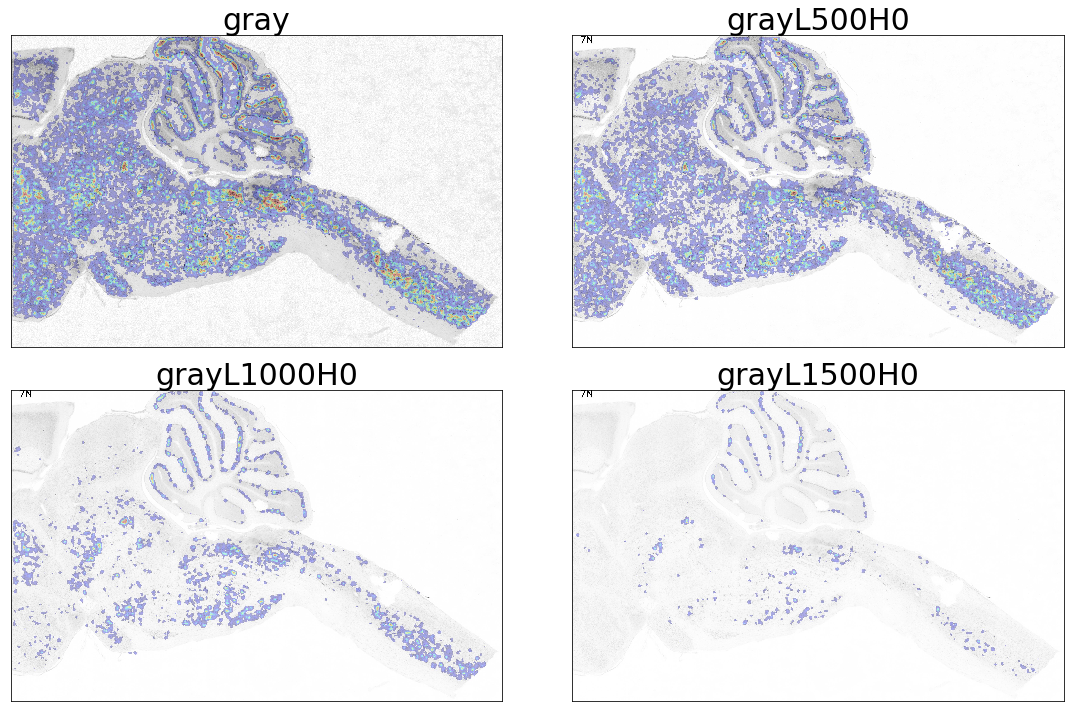

In [29]:
sm_viz_allDetectors = {}

for detector_id in [1,2,3,4]:
    sm_viz_fp = DataManager.get_scoremap_viz_filepath(stack=stack, downscale=downscale, fn=fn, structure=structure, detector_id=detector_id)
    download_from_s3(sm_viz_fp)
    sm_viz = imread(sm_viz_fp)
    
    sm_viz_allDetectors[detector_id] = sm_viz
    
detector_ids, vizs = zip(*sorted(sm_viz_allDetectors.items()))
titles = [detector_settings.loc[i]['input_version'] for i in detector_ids]

display_images_in_grids(vizs, titles=titles, nc=2);
plt.show();